In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import time

### Is Australia an exception to Zipf's Law?
A common tendency is for the distribution of city populations within a country to be Zipfian. With Melbourne recently overtaking Sydney in population (based on SUA classifications), this may suggest Australian cities may not share this characteristic. This notebook explores whether Australian cities appear to follow a Zipfian distribution.

In [15]:
df_hist = pd.read_csv('../data/australia/historical_pop.csv')
df_recent = pd.read_csv('../data/australia/aus_sua_pop.csv')
df_world = pd.read_csv('../data/australia/worldcities.csv')

In [17]:
df_world = df_world.dropna(subset = ['population'])
df_world = df_world[df_world['population'] >= 10000]
df_sorted = df_world.sort_values(by=['country', 'population'], ascending=[True, False])
df_sorted['rank'] = df_sorted.groupby('country').cumcount() + 1
country_counts = df_sorted['country'].value_counts()
df_sorted = df_sorted[df_sorted['country'].isin(country_counts[country_counts >= 50].index)]

In [19]:
oecd = ['Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
countries = df_world['country']

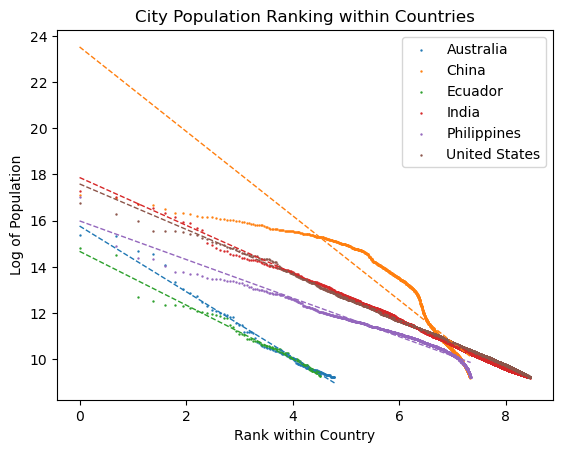

In [39]:
random_country = np.random.choice(countries, 5, replace=False)

for country, group in df_sorted.groupby('country'):
    if country in random_country or country == 'Australia':
        plt.scatter(np.log(group['rank']), np.log(group['population']), label=country, s=0.5)
        
        X = np.log(group['rank']).values.reshape(-1, 1)
        y = np.log(group['population']).values
        model = LinearRegression().fit(X, y)
        plt.plot(np.log(group['rank']), model.predict(X), linestyle='--', linewidth=1)

plt.xlabel('Rank within Country')
plt.ylabel('Log of Population')
plt.title('City Population Ranking within Countries')
plt.legend()
plt.show()

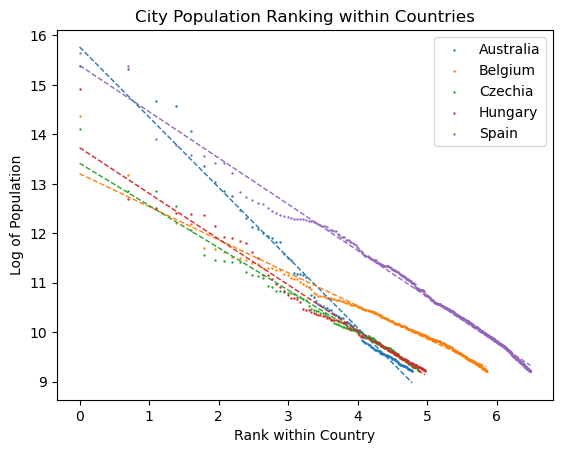

In [41]:
random_oecd = np.random.choice(oecd, 5, replace=False)

for country, group in df_sorted.groupby('country'):
    if country in random_oecd or country == 'Australia':
        plt.scatter(np.log(group['rank']), np.log(group['population']), label=country, s=0.5)
        
        X = np.log(group['rank']).values.reshape(-1, 1)
        y = np.log(group['population']).values
        model = LinearRegression().fit(X, y)
        plt.plot(np.log(group['rank']), model.predict(X), linestyle='--', linewidth=1)

plt.xlabel('Rank within Country')
plt.ylabel('Log of Population')
plt.title('City Population Ranking within Countries')
plt.legend()
plt.show()

At least visually, Australians tend to be more concentrated in high population cities (indicated by greater slope), however aside from this there isn't an extreme deviation from a Zipfian distribution (compared to, say, China, where there is substantial deviation from what is predicted by a Zipfian distribution).

It is useful to come up with a slightly more concrete measure to capture what is going on with Australia's distribution, and compare it to those of other countries. 3 measures are used; the slope of the relationship, capturing the relative concentration of population in high-ranked cities, the 'Maximum Residual', measuring the greatest deviation from the Zipfian distribution within a country, and the 'Delta of Top Cities', which measures the greatest difference between the predicted population by Zipf's Law and the observed value within the top 10 cities of a country.

In [24]:
df_sorted['slope'] = np.nan
df_sorted['max_residual'] = np.nan

for country, group in df_sorted.groupby('country'):
    X = np.log(group['rank']).values.reshape(-1, 1)
    y = np.log(group['population']).values
    model = LinearRegression().fit(X, y)
    
    df_sorted.loc[df_sorted['country'] == country, 'slope'] = model.coef_[0]
    
    residuals = y - model.predict(X)
    
    df_sorted.loc[df_sorted['country'] == country, 'max_residual'] = np.max(np.abs(residuals))
    
df_sorted['predicted'] = df_sorted['rank']/(df_sorted['rank'] + 1)
df_sorted['empirical'] = df_sorted['population'].shift(-1) / df_sorted['population']
df_sorted['delta'] = df_sorted['empirical']/df_sorted['predicted']
df_top = df_sorted[df_sorted['rank']<=10]

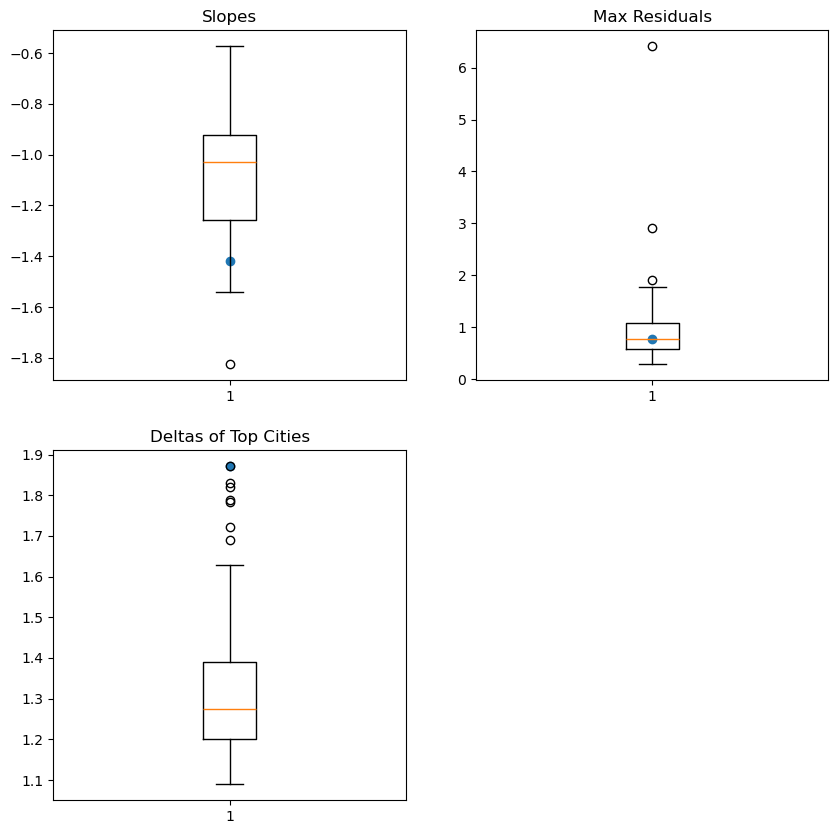

In [46]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.boxplot(x='slope', data=df_sorted.drop_duplicates('country'))
plt.scatter(1,df_sorted.loc[df_sorted['country'] == 'Australia']['slope'].unique()[0])
plt.title('Slopes')

plt.subplot(2,2,2)
plt.boxplot(x='max_residual', data=df_sorted.drop_duplicates('country'))
plt.scatter(1,df_sorted.loc[df_sorted['country'] == 'Australia']['max_residual'].unique()[0])
plt.title('Max Residuals')

plt.subplot(2,2,3)
delta_max = df_top.groupby('country')['delta'].max()
plt.boxplot(x=delta_max)
plt.scatter(1,delta_max.loc['Australia'])
plt.title('Deltas of Top Cities')

plt.show()

The 'Deltas of Top Cities' results indicate that Australia is exceptional in that the difference between the predicted city population assuming a Zipfian distribution and the actual one is unusually large (specifically for Sydney, the highlighted point). This suggests that it is not Australian cities in general that fail to follow a Zipfian distribution, rather, Australia's largest cities, Melbourne and Sydney alone are the deviation.

## Growth rates as an explanation?
The growth rates of Sydney and Melbourne over time are investigated to determine an explanation as to why these cities deviate from the Zipfian distribution.

In [58]:
df_all = df_hist.T
df_all.columns = df_all.iloc[0]
df_all = df_all[1:]
df_all = df_all.astype(float)
df_all.index = pd.to_numeric(df_all.index, errors='coerce')
df = df_all.iloc[4:]

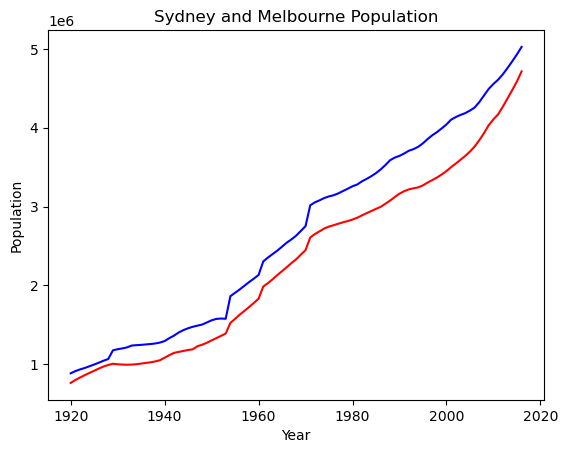

In [63]:
plt.plot(df['Sydney'], color='blue')
plt.plot(df['Melbourne'], color='red')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Sydney and Melbourne Population')
plt.show()

In [64]:
df = df.copy()
df['Combined'] = df['Sydney'] + df['Melbourne']
combined_growth = df.loc[1945:2016, 'Combined'].pct_change().mean()
df['Sydney_Predicted'] = df['Sydney']
df['Melbourne_Predicted'] = df['Melbourne']
df['Sydney_Varied_Predicted'] = df['Sydney']
df['Melbourne_Varied_Predicted'] = df['Melbourne']

for i in range(1946, 2017):
    df.loc[i,'Melbourne_Predicted'] = df.loc[i-1, 'Melbourne_Predicted'] * (1 + combined_growth)
    df.loc[i,'Sydney_Predicted'] = df.loc[i-1, 'Sydney_Predicted'] * (1 + combined_growth)
    
for i in range(1946, 2017):
    varied_growth = (df.loc[i,'Combined']-df.loc[i-1,'Combined'])/df.loc[i,'Combined']
    df.loc[i,'Melbourne_Varied_Predicted'] = df.loc[i-1, 'Melbourne_Varied_Predicted'] * (1 + varied_growth)
    df.loc[i,'Sydney_Varied_Predicted'] = df.loc[i-1, 'Sydney_Varied_Predicted'] * (1 + varied_growth)

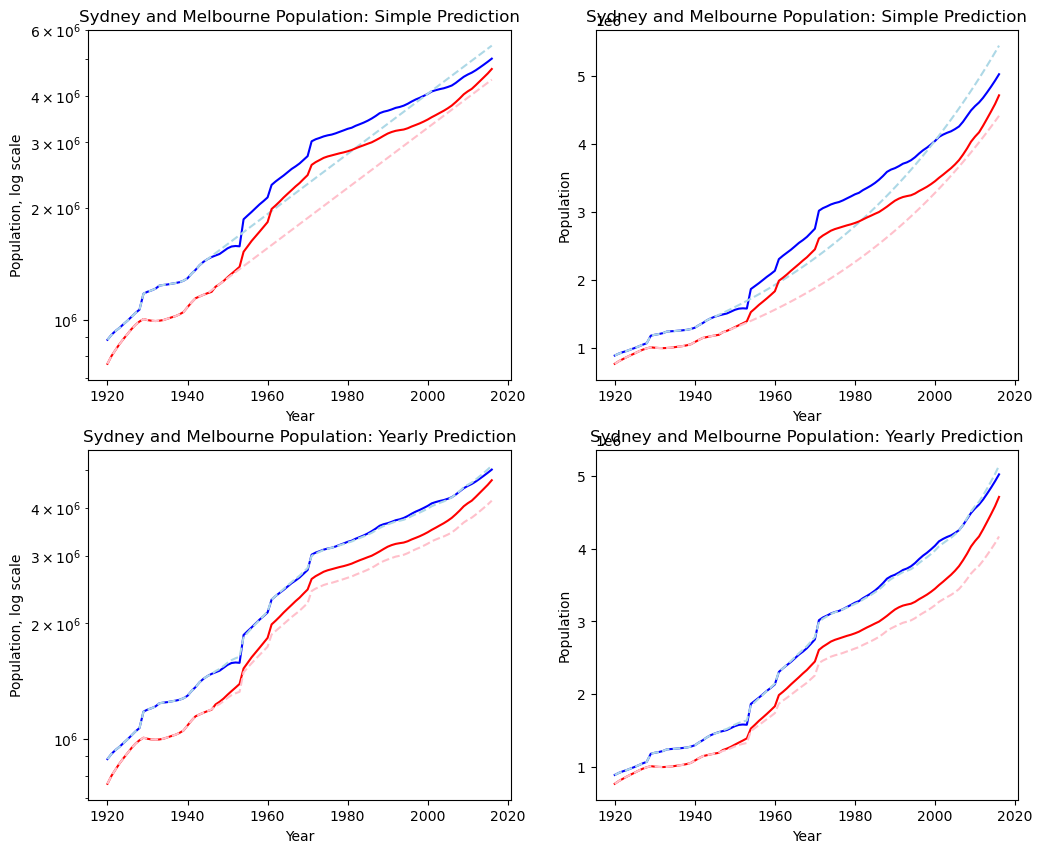

In [67]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(df['Sydney'], color='blue')
plt.plot(df['Sydney_Predicted'], color='lightblue', linestyle='--')
plt.plot(df['Melbourne'], color='red')
plt.plot(df['Melbourne_Predicted'], color='pink', linestyle='--')
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Population, log scale')
plt.title('Sydney and Melbourne Population: Simple Prediction')

plt.subplot(2,2,2)
plt.plot(df['Sydney'], color='blue')
plt.plot(df['Sydney_Predicted'], color='lightblue', linestyle='--')
plt.plot(df['Melbourne'], color='red')
plt.plot(df['Melbourne_Predicted'], color='pink', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Sydney and Melbourne Population: Simple Prediction')

plt.subplot(2,2,3)
plt.plot(df['Sydney'], color='blue')
plt.plot(df['Sydney_Varied_Predicted'], color='lightblue', linestyle='--')
plt.plot(df['Melbourne'], color='red')
plt.plot(df['Melbourne_Varied_Predicted'], color='pink', linestyle='--')
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Population, log scale')
plt.title('Sydney and Melbourne Population: Yearly Prediction')

plt.subplot(2,2,4)
plt.plot(df['Sydney'], color='blue')
plt.plot(df['Sydney_Varied_Predicted'], color='lightblue', linestyle='--')
plt.plot(df['Melbourne'], color='red')
plt.plot(df['Melbourne_Varied_Predicted'], color='pink', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Sydney and Melbourne Population: Yearly Prediction')

plt.show()

## Gibrat's Law
Gibrat's law states "if different cities grow randomly with the same expected growth rate and the same variance (Gibrat’s Law for means and variances of growth rate), then the limit distribution of city sizes converges to Zipf’s law".

By bootstrapping growth paths of Sydney and Melbourne assuming the same expected growth rate/variance (with growth rates of Sydney and Melbourne drawn from the same distribution of Australian city growth rates for a given year), we can see whether Sydney and Melbourne appear to deviate significantly from the growth path under these assumptions.

In [70]:
df_recent = df_recent.rename(columns={'SUA code':'code', 'Significant Urban Area':'sua'})
df_recent = df_recent[~df_recent['sua'].str.contains('Not in any Significant Urban Area')]
df_a = df_recent.set_index('sua').T
df_a = df_a.iloc[1:]
df_a.index = pd.to_numeric(df_a.index, errors='coerce')

cities_of_interest = ['Sydney', 'Melbourne']
df_selected_cities = df_a[cities_of_interest]
simulation_df = pd.DataFrame(index=df_selected_cities.index, columns=cities_of_interest)
simulation_df.iloc[0] = df_selected_cities.iloc[0]
growth_rates = df_a.pct_change()

mean_growth = growth_rates.mean(axis=1)
std_growth = growth_rates.std(axis=1)

In [76]:
num_bootstraps = 10000
bootstrap_results = pd.DataFrame(index=range(2001, 2023))
start_time = time.time()

for bootstrap in range(num_bootstraps):
    temp_df = pd.DataFrame(index=df_a.index, columns=df_a.columns)
    temp_df.iloc[0] = df_a.iloc[0]
    temp_df.index = pd.to_numeric(temp_df.index, errors='coerce')
    for i in range(2002, 2023):
        for city in temp_df.columns:
            temp_df.loc[i, city] = temp_df.loc[i-1, city] * (1 + np.random.normal(loc=mean_growth[i], scale=std_growth[i]))

    bootstrap_results = pd.concat([bootstrap_results, temp_df], axis=1)

sydney_upper = bootstrap_results['Sydney'].apply(lambda x: np.percentile(x, 97.5), axis=1)
sydney_lower = bootstrap_results['Sydney'].apply(lambda x: np.percentile(x, 2.5), axis=1)
sydney_median = bootstrap_results['Sydney'].apply(lambda x: np.percentile(x, 50), axis=1)
melbourne_upper = bootstrap_results['Melbourne'].apply(lambda x: np.percentile(x, 97.5), axis=1)
melbourne_lower = bootstrap_results['Melbourne'].apply(lambda x: np.percentile(x, 2.5), axis=1)    
melbourne_median = bootstrap_results['Melbourne'].apply(lambda x: np.percentile(x, 50), axis=1)

end_time = time.time()
print(end_time-start_time)

9578.601187229156


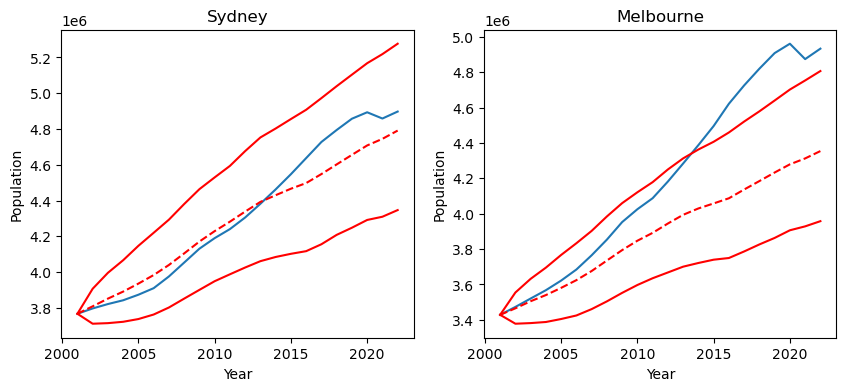

In [77]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(df_a['Sydney'])
plt.plot(sydney_upper, color='red')
plt.plot(sydney_lower, color='red')
plt.plot(sydney_median, color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Sydney')

plt.subplot(1,2,2)
plt.plot(df_a['Melbourne'])
plt.plot(melbourne_upper, color='red')
plt.plot(melbourne_lower, color='red')
plt.plot(melbourne_median, color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Melbourne')

plt.show()

This indicates Melbourne's growth rates do not have the same expected mean/variance as Sydney, and hence the lack of a Zipfian relationship between the cities may be attributed to a relatively rapid rate of growth in Melbourne since 2000.